## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested. 

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%): 
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [ ]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [1]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay 
#import scikitplot as skplt
#import gc

In [2]:
# Use GPU if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

mps


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [3]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [4]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [5]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [6]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [7]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [8]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [9]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [10]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))
    
    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [11]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [13]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),      # Instanciate embedding layer
                                            embedding_dim=embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,                   # Instanciate LSTM model
                            hidden_size=hidden,
                            num_layers=layers,
                            batch_first=True)
        
        self.fc = nn.Linear(in_features=hidden, 
                            out_features=num_classes)               # Instanciate fully connected layer
        
    def forward(self, x):                               # implement forward pass. This function will be called when executing the model
        vector_emb = self.embedding_layer(x)            # Get embedding vector
        y, h = self.rnn(vector_emb)                     # Pass embedding vector to LSTM model
        return self.fc(y[:, -1])                        # Pass last output to fully connected layer


#### Instantiate the model:

In [14]:
# model hyperparameters
EMBEDDING_SIZE = 300  
NEURONS = 256          
LAYERS = 2      
NUM_CLASSES = 4    

In [15]:
lstm_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
lstm_model

RNN_Model_1(
  (embedding_layer): Embedding(95811, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

### Accuracy function

In [16]:
def accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval()                            # set model to evaluation mode  
    model = model.to(device=device)         # move the model parameters to CPU/GPU
    with torch.no_grad():                   # disable gradient calculation
        for xi, yi in loader:                           
            xi = xi.to(device=device)                   # move to GPU
            yi = yi.to(device=device)                   # move to GPU
            scores = model(xi)                          # compute scores
            _, predictions = scores.max(dim=1)          # find the predicted class
            num_correct += (predictions == yi).sum()    # count correctly classified samples
            num_samples += predictions.size(0)          # count total number of samples
        return float(num_correct)/num_samples           # return accuracy

### Training function

In [17]:
def train(model, optimiser, epochs):
    model = model.to(device=device)         # move the model parameters to GPU
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()                           # set model to training mode    
            xi = xi.to(device=device)               # move to GPU
            yi = yi.to(device=device)               # move to GPU
            scores = model(xi)                      # compute scores

            cost = F.cross_entropy(input=scores, target=yi)  # compute loss

            optimiser.zero_grad()                   # reset gradients
            cost.backward()                         # compute gradients
            optimiser.step()                        # update parameters 
        
        acc = accuracy(model, val_loader)           # compute accuracy 

        print(f'Epoch: {epoch+1}, Cost: {cost:.4f}, Accuracy: {acc:.4f}')

### Training the model

In [18]:
torch.manual_seed(1)            # set seed for reproducibility
epochs = 20                     # number of epochs
lr = 5e-4                       # learning rate

# Adam optimiser 
optimiser = torch.optim.Adam(lstm_model.parameters(), lr=lr)            

In [19]:
train(lstm_model, optimiser=optimiser, epochs=epochs)

Epoch: 1, Cost: 0.3691, Accuracy: 0.8662
Epoch: 2, Cost: 0.3036, Accuracy: 0.8929
Epoch: 3, Cost: 0.2108, Accuracy: 0.9032
Epoch: 4, Cost: 0.1785, Accuracy: 0.9073
Epoch: 5, Cost: 0.0757, Accuracy: 0.9101
Epoch: 6, Cost: 0.1399, Accuracy: 0.9103
Epoch: 7, Cost: 0.1409, Accuracy: 0.9067
Epoch: 8, Cost: 0.0668, Accuracy: 0.9092
Epoch: 9, Cost: 0.0503, Accuracy: 0.9080
Epoch: 10, Cost: 0.1050, Accuracy: 0.9008
Epoch: 11, Cost: 0.0787, Accuracy: 0.9038
Epoch: 12, Cost: 0.0143, Accuracy: 0.9049
Epoch: 13, Cost: 0.0987, Accuracy: 0.9022
Epoch: 14, Cost: 0.0051, Accuracy: 0.9039
Epoch: 15, Cost: 0.0300, Accuracy: 0.9037
Epoch: 16, Cost: 0.0116, Accuracy: 0.9083
Epoch: 17, Cost: 0.0063, Accuracy: 0.9037
Epoch: 18, Cost: 0.0587, Accuracy: 0.9012
Epoch: 19, Cost: 0.0018, Accuracy: 0.9062
Epoch: 20, Cost: 0.0113, Accuracy: 0.9062


In [20]:
print(f'Test set Accuracy: {accuracy(lstm_model, test_loader):.4f}')

Test set Accuracy: 0.9033


### Text Sampling function

In [21]:
def sample_text(model, loader):
    model.eval()                            # set model to evaluation mode  
    model = model.to(device=device)         # move the model parameters to GPU
    with torch.no_grad():                   # disable gradient calculation
        for xi, yi in loader:                           
            xi = xi.to(device=device)                   # move to GPU
            yi = yi.to(device=device)                   # move to GPU
            scores = model(xi)                          # compute scores
            _, predictions = scores.max(dim=1)          # find the predicted class
            
            print(f'Predicted class: {labels[predictions[0]]}')      # print predicted class
            print(f'Actual class: {labels[yi[0]]}')                  # print actual class
            print(f'Text: \n{vocab.lookup_tokens(xi[0].tolist())}')   # print text
            break                                                     # break after first sample
    

#### Let's make some predictions:

In [30]:
sample_text(lstm_model, test_loader)

Predicted class: World
Actual class: World
Text: 
['uk', 'to', 'host', 'mideast', 'conference', 'report', 'london', ',', 'december', '6', '(', 'islamonline', '.', 'net', 'amp', 'news', 'agencies', ')', '-', 'britain', 'received', 'a', 'green', 'light', 'from', 'washington', 'to', 'host', 'a', 'conference', 'on', 'middle', 'east', 'peace', 'after', 'the', 'palestinian', 'presidential', 'elections', ',', 'a', 'british', 'news', 'paper', 'reported', 'monday', ',', 'december', '6', '.']


### Confusion matrix

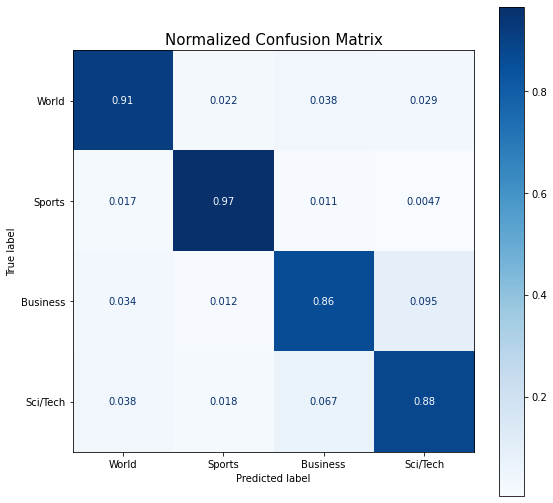

In [27]:
y_true = []                                     # initialize true labels 
y_pred = []                                     # initialize predicted labels
with torch.no_grad():
    for xi, yi in test_loader:                  # iterate over test data
        xi = xi.to(device=device)
        yi = yi.to(device=device)
        scores = lstm_model(xi)                 # compute scores
        _, predictions = scores.max(dim=1)      # find the predicted class
        y_true.extend(yi.tolist())              # append true labels
        y_pred.extend(predictions.tolist())     # append predicted labels
    
# plot confusion matrix
fig, axs = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, 
                                        normalize='true', cmap='Blues', ax=axs)

axs.set_title('Normalized Confusion Matrix', fontsize=15)
plt.show()

The confusion matrix shows that our model performs best on the **Sports** class with 97% of the samples correctly classified. On the other hand, it performs worst on the **Business** and **Sci/Tech** classes. The most common mistake our model seems to make is to clasiffy as **Sci/Tech** samples that actually belong to the **Business** class. 